Saving Dataset.csv to Dataset (9).csv
Linear Regression trained successfully.
Random Forest trained successfully.
Gradient Boosting trained successfully.

Linear Regression Evaluation Metrics:
  MAE  : 0.220
  RMSE : 0.339
  R²   : -2.252
  MAPE : 136.553%

Random Forest Evaluation Metrics:
  MAE  : 0.135
  RMSE : 0.179
  R²   : 0.099
  MAPE : 91.704%

Gradient Boosting Evaluation Metrics:
  MAE  : 0.135
  RMSE : 0.177
  R²   : 0.120
  MAPE : 90.284%

Sample Predictions:
      Predicted_Occupancy_Rate
1608                  0.447510
173                   0.451737
463                   0.293217
2353                  0.436150
2129                  0.252187


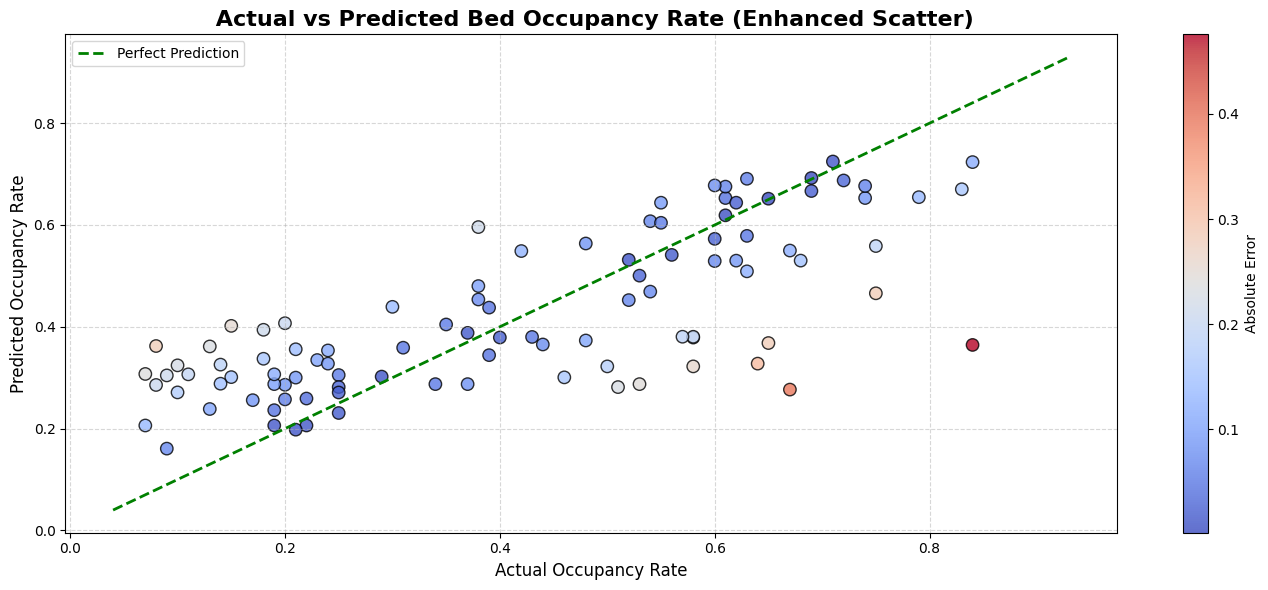

In [10]:
# Step 1: Upload Dataset.csv
from google.colab import files
uploaded = files.upload()

# Step 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 3: Load dataset
df = pd.read_csv('Dataset.csv')

# Step 4: Split 20% unseen data
df, unseen_data = train_test_split(df, test_size=0.2, random_state=42)

# Step 5: Clean & preprocess training data
df['All Bed Occupancy Rate'] = df['All Bed Occupancy Rate'].fillna(df['All Bed Occupancy Rate'].median())
if 'ICU Bed Source Last Updated' in df.columns:
    df = df.drop('ICU Bed Source Last Updated', axis=1)

numerical_cols_with_missing = ['Staffed All Beds', 'Staffed ICU Beds', 'Licensed All Beds',
                               'ICU Bed Occupancy Rate', 'Population', 'Population (20+)', 'Population (65+)']
for col in numerical_cols_with_missing:
    if col in df.columns and df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

categorical_cols_with_missing = ['ICU Bed Source']
for col in categorical_cols_with_missing:
    if col in df.columns and df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

numerical_cols_for_outlier_handling = ['Staffed All Beds', 'Staffed ICU Beds', 'Licensed All Beds',
                                       'All Bed Occupancy Rate', 'ICU Bed Occupancy Rate', 'Population',
                                       'Population (20+)', 'Population (65+)']
for col in numerical_cols_for_outlier_handling:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]

# Step 6: Feature engineering
df['Staffed_Beds_Population'] = df['Staffed All Beds'] * df['Population']
df['Licensed_Beds_Population'] = df['Licensed All Beds'] * df['Population']
df['Staffed_Beds_Squared'] = df['Staffed All Beds'] ** 2
df['Population_Squared'] = df['Population'] ** 2

# One-hot encoding
cat_cols = ['State', 'County Name', 'ICU Bed Source']
cat_cols = [col for col in cat_cols if col in df.columns]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
df = pd.concat([df.drop(cat_cols, axis=1), encoded_df], axis=1)

# Step 7: Split data
target_col = 'All Bed Occupancy Rate'
X = df.drop(target_col, axis=1)
y = df[target_col]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 8: Scale & Impute
numerical_cols = ['Staffed All Beds', 'Staffed ICU Beds', 'Licensed All Beds',
                  'ICU Bed Occupancy Rate', 'Population', 'Population (20+)', 'Population (65+)',
                  'Staffed_Beds_Population', 'Licensed_Beds_Population', 'Staffed_Beds_Squared', 'Population_Squared']
numerical_cols = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Step 9: Train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}
for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    print(f"{name} trained successfully.")

# Step 10: Evaluate models
epsilon = 1e-10
for name, model in models.items():
    y_pred = model.predict(X_test_imputed)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    print(f"\n{name} Evaluation Metrics:")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAPE : {mape:.3f}%")

# Step 11: Predict on unseen 20%
unseen_data_clean = unseen_data.copy()
if 'ICU Bed Source Last Updated' in unseen_data_clean.columns:
    unseen_data_clean = unseen_data_clean.drop('ICU Bed Source Last Updated', axis=1)

# Fill missing
for col in numerical_cols_with_missing:
    if col in unseen_data_clean.columns:
        unseen_data_clean[col] = unseen_data_clean[col].fillna(unseen_data_clean[col].median())
for col in categorical_cols_with_missing:
    if col in unseen_data_clean.columns:
        unseen_data_clean[col] = unseen_data_clean[col].fillna(unseen_data_clean[col].mode()[0])

# Feature engineering for unseen data
unseen_data_clean['Staffed_Beds_Population'] = unseen_data_clean['Staffed All Beds'] * unseen_data_clean['Population']
unseen_data_clean['Licensed_Beds_Population'] = unseen_data_clean['Licensed All Beds'] * unseen_data_clean['Population']
unseen_data_clean['Staffed_Beds_Squared'] = unseen_data_clean['Staffed All Beds'] ** 2
unseen_data_clean['Population_Squared'] = unseen_data_clean['Population'] ** 2

encoded_unseen = encoder.transform(unseen_data_clean[cat_cols])
encoded_unseen_df = pd.DataFrame(encoded_unseen, columns=encoder.get_feature_names_out(cat_cols), index=unseen_data_clean.index)
unseen_data_clean = pd.concat([unseen_data_clean.drop(cat_cols, axis=1), encoded_unseen_df], axis=1)

# Align with training features
for col in X_train.columns:
    if col not in unseen_data_clean.columns:
        unseen_data_clean[col] = 0
unseen_data_clean = unseen_data_clean[X_train.columns]

# Scale & impute
unseen_data_clean[numerical_cols] = scaler.transform(unseen_data_clean[numerical_cols])
unseen_imputed = imputer.transform(unseen_data_clean)

# Predict using best model
chosen_model = models['Gradient Boosting']
predictions = chosen_model.predict(unseen_imputed)
unseen_data['Predicted_Occupancy_Rate'] = predictions

# Save predictions
unseen_data.to_csv('Predicted_UnseenData.csv', index=False)
print("\nSample Predictions:")
print(unseen_data[['Predicted_Occupancy_Rate']].head())


!pip install seaborn scikit-learn matplotlib --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

#  Load the dataset (update path if needed)
df = pd.read_csv('Dataset.csv')

#  Drop irrelevant or mostly missing columns
df = df.drop(columns=["ICU Bed Source Last Updated"])

#  Drop rows where target is missing
df = df.dropna(subset=["All Bed Occupancy Rate"])

#  Separate feature types
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_cols.remove("All Bed Occupancy Rate")
categorical_cols = ["State", "County Name", "ICU Bed Source"]

#  Impute numerical features
imputer = SimpleImputer(strategy="median")
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

#  One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

#  Combine processed features
df_model = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

#  Final cleanup
df_model = df_model.dropna()

#  Prepare data for modeling
X = df_model.drop(columns=["All Bed Occupancy Rate"])
y = df_model["All Bed Occupancy Rate"]

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train the model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

#  Predictions
y_pred = model.predict(X_test_scaled)

#  Enhanced Scatter Plot: Actual vs Predicted
plt.figure(figsize=(14, 6))
errors = np.abs(y_test.values[:100] - y_pred[:100])

scatter = plt.scatter(
    y_test.values[:100],
    y_pred[:100],
    c=errors,
    cmap='coolwarm',
    edgecolor='k',
    s=80,
    alpha=0.8
)

#  Identity line (perfect prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'g--', linewidth=2, label='Perfect Prediction')

# Labels & Title
plt.title(" Actual vs Predicted Bed Occupancy Rate (Enhanced Scatter)", fontsize=16, weight='bold')
plt.xlabel("Actual Occupancy Rate", fontsize=12)
plt.ylabel("Predicted Occupancy Rate", fontsize=12)
plt.colorbar(scatter, label="Absolute Error")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

